In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sys
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Ignore warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('ggplot')

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# %%
import pandas as pd
import sys
import os

# Add the src directory to the path so we can import our modules
sys.path.append(os.path.abspath('..'))

# %%
import os
# os.getcwd()
# # set to 1 level up
os.chdir(os.path.dirname(os.getcwd()))
# os.getcwd()


# %%
merchants = pd.read_csv("data/merchants.csv")
merchants=merchants.rename(columns={'country': 'merchant_country'})
merchants.head()

# %%
# Load users data
users = pd.read_csv("data/users.csv")
users = users.rename(columns={'country': 'user_country'})
if 'sex' in users.columns:
    users = users.drop('sex', axis=1)

# %%
transactions = pd.read_json("data/transactions.json", lines=True)


# %% [markdown]
# ## Data Merging: Best Practices

# %% [markdown]
# We use the `validate='many_to_one'` parameter in pandas merges to ensure data integrity and prevent silent multiplication errors that could corrupt our fraud detection models by creating artificial patterns or duplications in the dataset.

# %%
# Perform the merge with validation
trans_user = pd.merge(
    transactions, 
    users, 
    on='user_id', 
    how='left',
    validate='many_to_one'  # Ensure many-to-one relationship: many transactions to one user
)

# %%
# Perform the merge with validation
df_merged = pd.merge(
    trans_user, 
    merchants, 
    on='merchant_id', 
    how='left',
    validate='many_to_one'  # Ensure many-to-one relationship: many transactions to one merchant
)

# %% [markdown]
# ## Feature Engineering
# 
# Adding time-based features for transaction analysis

# %%
# Import the feature engineering function
from src.feature_engineering.time_features import calculate_time_since_last_transaction

# Apply the function to calculate time since last transaction
df_merged = calculate_time_since_last_transaction(df_merged)

# %% [markdown]
# ## Location-based Feature Engineering
# 
# Extract country and city information from location coordinates using vectorized operations

# %%
# Import the location feature engineering functions
from src.feature_engineering.geo_features import extract_location_info

df_merged = extract_location_info(df_merged, location_column='location')

# Display the new columns
print("\nSample rows with extracted location data:")
df_merged[['location', 'country', 'city', 'administrative_region_1', 'administrative_region_2']].head()

# %% [markdown]
# ## Convert Country Codes to Full Names
# 
# Convert ISO 3166-1 alpha-2 country codes to full country names so they would match other features

# %%
# Import the country code conversion function
from src.feature_engineering.geo_features import convert_country_codes_to_names

# Convert transaction country codes to full country names
df_merged = convert_country_codes_to_names(
    df_merged,
    country_col='country',
    new_col_name='transaction_country_name',
    keep_original=True
)

# Display results with the full country names
print("Sample rows with converted country names:")
df_merged[[
    'country', 'transaction_country_name',
    'user_country', 'merchant_country',
]].head(10)

# %% [markdown]
# ## Time Features: Date, Hour, Weekday, and Week Number
# 
# Extract time-related features from transaction timestamps for fraud detection

# %%
# Import the time feature engineering functions
from src.feature_engineering.time_features import (
    extract_hour_from_timestamp,
    extract_weekday_from_timestamp,
    extract_date_from_timestamp,
    extract_week_of_year
)

# Extract just the date component (YYYY-MM-DD)
df_merged = extract_date_from_timestamp(
    df_merged,
    timestamp_col='timestamp',
    new_col_name='date'
)

# Extract hour of day (0-23)
df_merged = extract_hour_from_timestamp(
    df_merged,
    timestamp_col='timestamp',
    new_col_name='hour_of_day',
    convert_to_categorical=True
)

# Extract day of week (0=Monday, 6=Sunday)
df_merged = extract_weekday_from_timestamp(
    df_merged,
    timestamp_col='timestamp',
    new_col_name='day_of_week',
    convert_to_categorical=True,
    as_name=False  # Keep as numbers for modeling
)

# Create a more human-readable version for visualization
df_merged = extract_weekday_from_timestamp(
    df_merged,
    timestamp_col='timestamp',
    new_col_name='weekday_name',
    as_name=True
)

# Extract week number of the year (1-53)
df_merged = extract_week_of_year(
    df_merged,
    timestamp_col='timestamp',
    new_col_name='week_of_year',
    convert_to_categorical=True
)

# Display the new time features
print("Sample rows with extracted time features:")
df_merged[[
    'timestamp',
    'date',
    'hour_of_day',
    'day_of_week',
    'weekday_name',
    'week_of_year'
]].head()

# %% [markdown]
# ## Country Match Feature
# 
# Add a binary feature indicating whether the user's country matches the transaction country

# %%
# Import the country match feature function
from src.feature_engineering.geo_features import add_country_match_feature

# Apply the function to check if user country matches transaction country
df_merged = add_country_match_feature(
    df_merged, 
    user_country_col='user_country',
    transaction_country_col='transaction_country_name',
    new_col_name='is_user_transaction_country_match'
)

# Display the distribution of the new feature
print("Distribution of user-transaction country matches:")
df_merged['is_user_transaction_country_match'].value_counts()

# Show a sample of rows with the new feature
df_merged[['user_country', 'country', 'is_user_transaction_country_match']].head(10)

# %%
# Count the number of transactions by country
country_counts = df_merged['country'].value_counts()
print("Transaction counts by country:")
country_counts.head(10)




Loading formatted geocoded file...

Sample rows with extracted location data:
Sample rows with converted country names:
Sample rows with extracted time features:
Distribution of user-transaction country matches:
Transaction counts by country:


country
RU    60837
NO    53581
GB    40057
ES    30211
FR    27169
SE    27153
IT    26358
TR    25974
UA    25352
FI    20642
Name: count, dtype: int64

In [3]:
# Encode categorical features
categorical_cols = ['user_id', 'merchant_id', 'channel', 'currency', 'device', 'payment_method', 
                    'education', 'primary_source_of_income', 'user_country', 'category', 
                   'merchant_country', 'is_first_time_merchant']

# Add any additional categorical columns extracted from location
if 'country' in df_merged.columns:
    categorical_cols.append('country')
if 'city' in df_merged.columns:
    categorical_cols.append('city')
if 'administrative_region_1' in df_merged.columns:
    categorical_cols.append('administrative_region_1')

# Apply label encoding
label_encoders = {}
for col in categorical_cols:
    if col in df_merged.columns:
        le = LabelEncoder()
        df_merged[col + '_encoded'] = le.fit_transform(df_merged[col].astype(str))
        label_encoders[col] = le

In [4]:
# Prepare the data for modeling
# Drop columns that won't be used for modeling
cols_to_drop = ['transaction_id', 'user_id', 'merchant_id', 'timestamp', 'location', 'prev_timestamp', 'signup_date', 'date']
cols_to_drop.extend([col for col in categorical_cols if col in df_merged.columns])

# Keep only the encoded versions of categorical columns
modeling_df = df_merged.drop(columns=[col for col in cols_to_drop if col in df_merged.columns])

# Display the prepared dataframe
print("Shape of modeling dataframe:", modeling_df.shape)
modeling_df.head()

Shape of modeling dataframe: (500000, 36)


,amount,is_international,session_length_seconds,is_fraud,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,time_since_last_txn,administrative_region_2,transaction_country_name,hour_of_day,day_of_week,weekday_name,week_of_year,is_user_transaction_country_match,user_id_encoded,merchant_id_encoded,channel_encoded,currency_encoded,device_encoded,payment_method_encoded,education_encoded,primary_source_of_income_encoded,user_country_encoded,category_encoded,merchant_country_encoded,is_first_time_merchant_encoded,country_encoded,city_encoded,administrative_region_1_encoded
290822,19.09,1,811,0,56,477.69,243.18,0.571079,0.631421,2,26.85,37,0,-9.0,Farsund,Norway,10,5,Saturday,1,0,0,905,2,0,1,2,1,1,4,4,1,0,43,40893,1033
197951,32.24,1,233,0,56,477.69,243.18,0.571079,0.859810,2,197.43,115,1,24300.0,,Türkiye,16,5,Saturday,1,0,0,244,2,0,0,3,1,1,4,3,12,1,56,3643,6
187979,4.29,1,521,0,56,477.69,243.18,0.571079,0.934815,5,18.36,68,0,344100.0,,Russian Federation,16,2,Wednesday,2,0,0,331,0,0,0,2,1,1,4,4,12,1,48,26587,482
137034,67.00,1,1149,0,56,477.69,243.18,0.571079,0.859404,6,123.91,94,1,497820.0,,Russian Federation,10,1,Tuesday,3,0,0,330,0,0,2,2,1,1,4,3,1,0,48,27749,622
401318,3.59,1,261,0,56,477.69,243.18,0.571079,0.516453,1,0.98,52,1,15629100.0,Obshtina Strelcha,Bulgaria,8,0,Monday,29,0,0,970,0,0,1,3,1,1,4,0,6,1,6,37221,705


In [5]:
# 1. Drop only the columns you know are dates/times
date_cols = ['timestamp', 'date', 'signup_date', 'weekday_name']  # Add others if needed
for col in date_cols:
    if col in modeling_df.columns:
        modeling_df = modeling_df.drop(col, axis=1)
        print(f"Dropped date/time column: {col}")

# 2. Drop columns that contain dicts (e.g., 'location')
for col in modeling_df.columns:
    if modeling_df[col].apply(lambda x: isinstance(x, dict)).any():
        modeling_df = modeling_df.drop(col, axis=1)
        print(f"Dropped dict column: {col}")

# 3. Encode all object (string) columns to categorical codes
for col in modeling_df.select_dtypes(include=['object']).columns:
    modeling_df[col] = modeling_df[col].astype('category').cat.codes
    print(f"Encoded categorical column: {col}")

Dropped date/time column: weekday_name
Encoded categorical column: administrative_region_2
Encoded categorical column: transaction_country_name


In [6]:
# Drop columns that won't be used for modeling
cols_to_drop = ['transaction_id', 'user_id', 'merchant_id', 'timestamp', 'location', 'prev_timestamp', 'signup_date', 'date']
cols_to_drop.extend([col for col in categorical_cols if col in df_merged.columns])

# Keep only the encoded versions of categorical columns
modeling_df = df_merged.drop(columns=[col for col in cols_to_drop if col in df_merged.columns])

# Display the prepared dataframe
print("Shape of modeling dataframe:", modeling_df.shape)
modeling_df.head()

Shape of modeling dataframe: (500000, 36)


,amount,is_international,session_length_seconds,is_fraud,age,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,time_since_last_txn,administrative_region_2,transaction_country_name,hour_of_day,day_of_week,weekday_name,week_of_year,is_user_transaction_country_match,user_id_encoded,merchant_id_encoded,channel_encoded,currency_encoded,device_encoded,payment_method_encoded,education_encoded,primary_source_of_income_encoded,user_country_encoded,category_encoded,merchant_country_encoded,is_first_time_merchant_encoded,country_encoded,city_encoded,administrative_region_1_encoded
290822,19.09,1,811,0,56,477.69,243.18,0.571079,0.631421,2,26.85,37,0,-9.0,Farsund,Norway,10,5,Saturday,1,0,0,905,2,0,1,2,1,1,4,4,1,0,43,40893,1033
197951,32.24,1,233,0,56,477.69,243.18,0.571079,0.859810,2,197.43,115,1,24300.0,,Türkiye,16,5,Saturday,1,0,0,244,2,0,0,3,1,1,4,3,12,1,56,3643,6
187979,4.29,1,521,0,56,477.69,243.18,0.571079,0.934815,5,18.36,68,0,344100.0,,Russian Federation,16,2,Wednesday,2,0,0,331,0,0,0,2,1,1,4,4,12,1,48,26587,482
137034,67.00,1,1149,0,56,477.69,243.18,0.571079,0.859404,6,123.91,94,1,497820.0,,Russian Federation,10,1,Tuesday,3,0,0,330,0,0,2,2,1,1,4,3,1,0,48,27749,622
401318,3.59,1,261,0,56,477.69,243.18,0.571079,0.516453,1,0.98,52,1,15629100.0,Obshtina Strelcha,Bulgaria,8,0,Monday,29,0,0,970,0,0,1,3,1,1,4,0,6,1,6,37221,705


In [7]:
print(modeling_df.dtypes)
print(modeling_df.head(3).T)  # Transpose to see all columns easily

amount                                float64
is_international                        int64
session_length_seconds                  int64
is_fraud                                int64
age                                     int64
sum_of_monthly_installments           float64
sum_of_monthly_expenses               float64
risk_score                            float64
trust_score                           float64
number_of_alerts_last_6_months          int64
avg_transaction_amount                float64
account_age_months                      int64
has_fraud_history                       int64
time_since_last_txn                   float64
administrative_region_2                object
transaction_country_name               object
hour_of_day                          category
day_of_week                          category
weekday_name                           object
week_of_year                         category
is_user_transaction_country_match       int64
user_id_encoded                   

In [8]:
# 1. Drop only the columns you know are dates/times
date_cols = ['timestamp', 'date', 'signup_date', 'weekday_name']  # Add others if needed
for col in date_cols:
    if col in modeling_df.columns:
        modeling_df = modeling_df.drop(col, axis=1)
        print(f"Dropped date/time column: {col}")

# 2. Drop columns that contain dicts (e.g., 'location')
for col in modeling_df.columns:
    if modeling_df[col].apply(lambda x: isinstance(x, dict)).any():
        modeling_df = modeling_df.drop(col, axis=1)
        print(f"Dropped dict column: {col}")

# 3. Encode all object (string) columns to categorical codes
for col in modeling_df.select_dtypes(include=['object']).columns:
    modeling_df[col] = modeling_df[col].astype('category').cat.codes
    print(f"Encoded categorical column: {col}")

Dropped date/time column: weekday_name
Encoded categorical column: administrative_region_2
Encoded categorical column: transaction_country_name


In [9]:
# Define features and target
X = df_merged.drop('is_fraud', axis=1)
y = df_merged['is_fraud']

# Now X should only have numeric columns!
print(X.dtypes)

transaction_id                               object
timestamp                            datetime64[ns]
user_id                                      object
merchant_id                                  object
amount                                      float64
channel                                      object
currency                                     object
device                                       object
location                                     object
payment_method                               object
is_international                              int64
session_length_seconds                        int64
is_first_time_merchant                        int64
age                                           int64
education                                    object
primary_source_of_income                     object
sum_of_monthly_installments                 float64
sum_of_monthly_expenses                     float64
user_country                                 object
signup_date 

In [10]:
# Define features and target
X = modeling_df.drop('is_fraud', axis=1)
y = modeling_df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Fraud samples in training set: {y_train.sum()}")
print(f"Fraud samples in test set: {y_test.sum()}")

Training set: 400000 samples
Test set: 100000 samples
Fraud samples in training set: 33929
Fraud samples in test set: 8482


In [11]:
print(X_train.columns)

Index(['amount', 'is_international', 'session_length_seconds', 'age', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score', 'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'time_since_last_txn', 'administrative_region_2', 'transaction_country_name', 'hour_of_day', 'day_of_week', 'week_of_year',
       'is_user_transaction_country_match', 'user_id_encoded', 'merchant_id_encoded', 'channel_encoded', 'currency_encoded', 'device_encoded', 'payment_method_encoded', 'education_encoded',
       'primary_source_of_income_encoded', 'user_country_encoded', 'category_encoded', 'merchant_country_encoded', 'is_first_time_merchant_encoded', 'country_encoded', 'city_encoded',
       'administrative_region_1_encoded'],
      dtype='object')


In [14]:
# Apply SMOTE to handle class imbalance
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#print(f"Original training set shape: {X_train.shape}")
#print(f"Resampled training set shape: {X_train_resampled.shape}")
#print(f"Fraud samples in original training set: {y_train.sum()}")
#print(f"Fraud samples in resampled training set: {y_train_resampled.sum()}")

X_train_resampled = X_train
y_train_resampled = y_train

In [15]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    scale_pos_weight=1,
    random_state=42,
    eval_metric='auc'  
)
X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_train_resampled = X_train_resampled.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

# Train the model
xgb_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    #early_stopping_rounds=50,
    verbose=100
)

[0]	validation_0-auc:0.57172	validation_1-auc:0.56364
[99]	validation_0-auc:0.63327	validation_1-auc:0.56932


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1200x800 with 0 Axes>

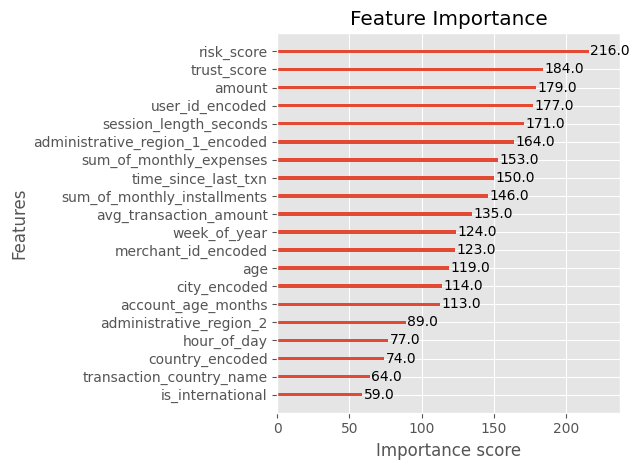

In [16]:
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [17]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values('Importance', ascending=False)

print("Top 20 most important features:")
importance_df.head(20)

Top 20 most important features:


,Feature,Importance
11,has_fraud_history,135.793793
7,trust_score,17.319685
1,is_international,13.570934
6,risk_score,12.119550
21,channel_encoded,8.685844
25,primary_source_of_income_encoded,8.376120
27,category_encoded,8.266455
18,is_user_transaction_country_match,8.156011
23,payment_method_encoded,8.071923
0,amount,8.043040


In [18]:
# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.5693


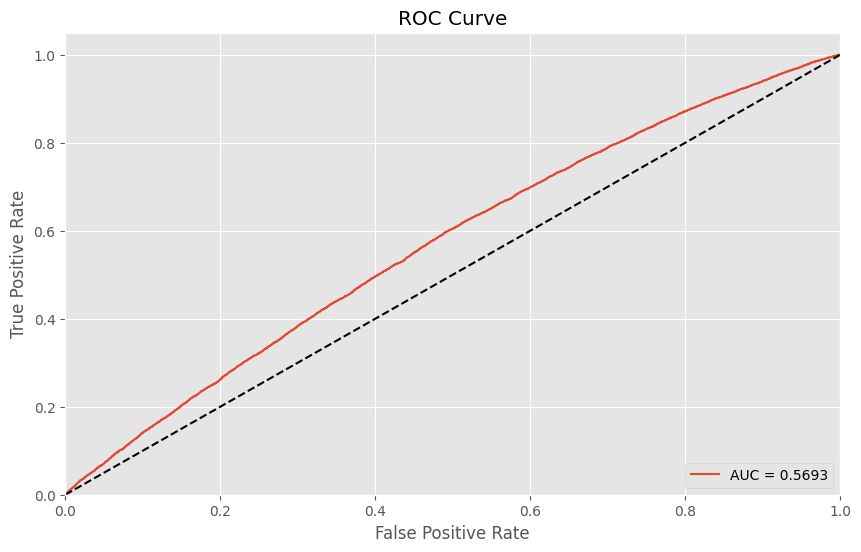

In [19]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

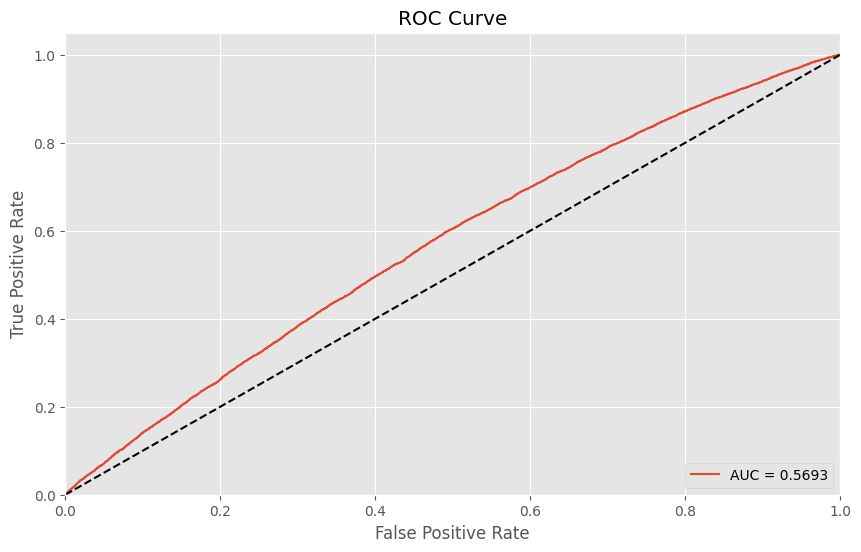

In [20]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [24]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     91518
           1       0.00      0.00      0.00      8482

    accuracy                           0.92    100000
   macro avg       0.46      0.50      0.48    100000
weighted avg       0.84      0.92      0.87    100000



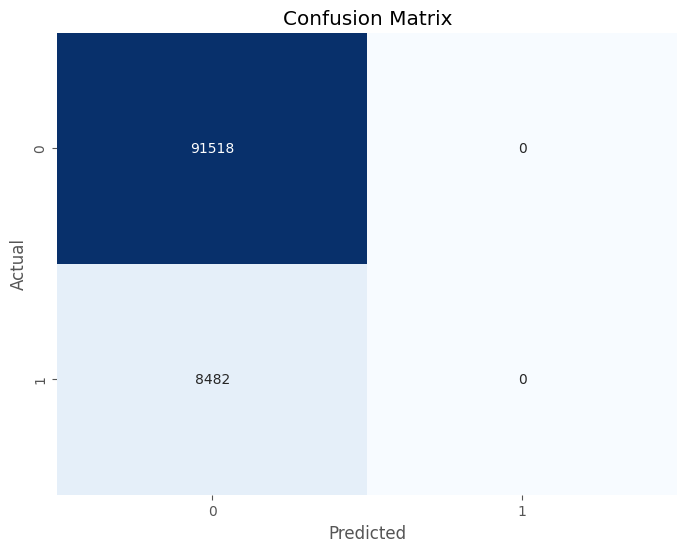

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()